# TP Session Apprentissage Supervisé

__Author__: José A. López  
__Groupe__: 420-A52-BB gr.000277  


## Project Description
The company has recently developed an action plan to improve its classification rate for text documents produced by its various departments. To this end, it is proposed to set up a model to categorize text documents.


### Data set Réference
http://mlg.ucd.ie/datasets/bbc.html  (BBCSport Fulltext)

## Approach
The objective is to develop a model that will predict the likelihood that a document will belong to a certain category. 
The model must be developed on a subset of data that will be provided to you. The model will then be tested on a subset of data that will be hidden during the learning phase. As a result, the quality of the model will be tested on data that are not part of the learning set. Input text files must be put in folder "input/" relative to the path of the Notebook.

In [1]:

# Load libraries and set up default values
from sklearn import (model_selection, preprocessing, linear_model, naive_bayes
                     , metrics, svm)
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,TfidfTransformer
from sklearn import decomposition, ensemble

import xgboost # A lot more optimized than sci-kit learn one
import string
import numpy as np
import pandas as pd
import scipy
import os
import io
import aux_functions_mod  #Custom own functions

#Text preprocessing tools
import re
import nltk
import string
from nltk.corpus import stopwords
%matplotlib inline

# Visualization libraries
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 24
# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Pandas display options 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

# Silence Jupyter Notebook Warnings
import warnings
warnings.filterwarnings('ignore')

# Set fix random states
FIX_RAND_STATE = 421 #Set fixed seed for random states
np.random.seed(FIX_RAND_STATE)

In [2]:
# Load data set
container_path = "input/"

cat_names = list(os.walk(container_path))[0][1]

cat_names_dic = {v:k for (k,v) in enumerate(cat_names)}
documents = load_files(container_path, categories = cat_names
                       , encoding='utf-8', decode_error='ignore')
dir(documents) #['DESCR', 'data', 'filenames', 'target', 'target_names']


# Split on train and test sets
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(documents.data
                                      , documents.target, test_size=0.25
                                      , random_state = FIX_RAND_STATE)


## Data Exploration

First, we explore the proportion of examples contained in each category. 

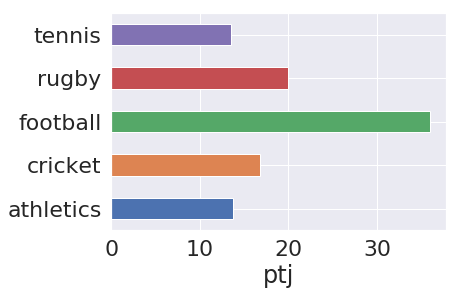

In [3]:
# Explore categorie distributios
category_proportions = pd.Series(pd.Series(documents.target).value_counts() / len(
        documents.target)*100, name = 'ptj').sort_index().round(2)
category_proportions.index = cat_names
f, ax = plt.subplots()
category_proportions.plot(kind='barh')
plt.xlabel(category_proportions.name)
plt.show()

As expected, the proportions are not equal. However, the difference is not drastic and in my experience such a difference should not cause problems. That usually happens with extremely unequal proportions, for example one class having 97% or more of the examples and the data is not being easily separable. In those cases is difficult to avoid classifiers to class all in to the dominant class.  We will in any case use the classification in the most frequent class as the our base model.


We can also explore which are the most frequent words in each category.
The result shows that words of common use in any type of speech are the ones that appear the most. However, most likely these types of terms do not have much predictive power. So it will be necessary to carry out some transformations and filtering part of the raw text in the data transformation process that will be included in a pipe line. 


Top words for category : athletics


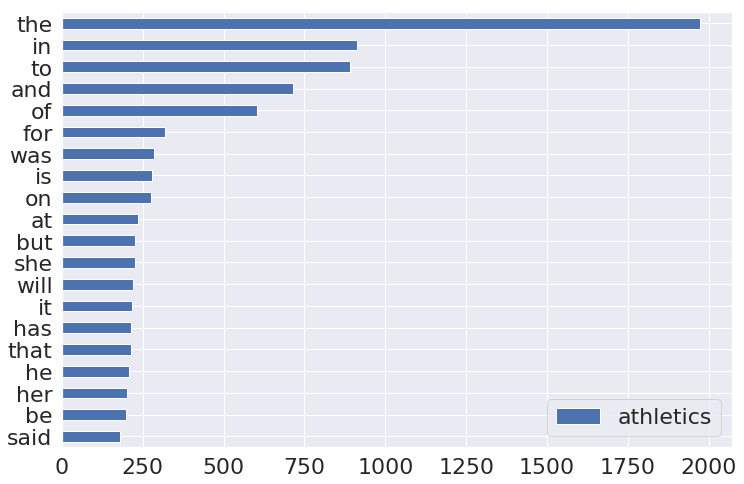

Top words for category : cricket


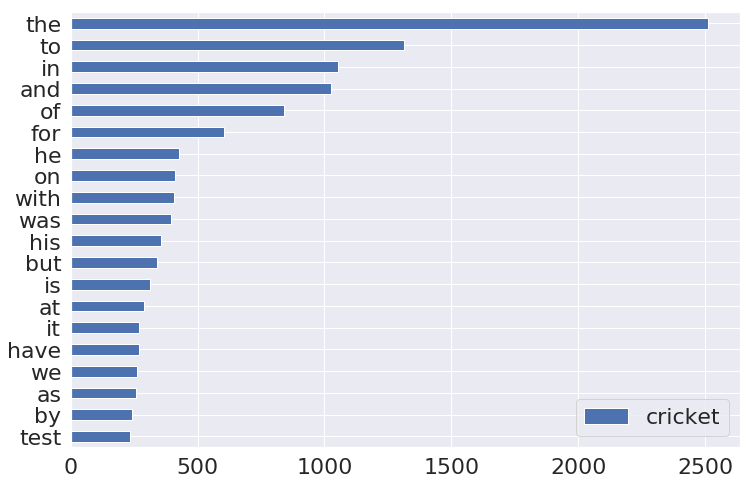

Top words for category : football


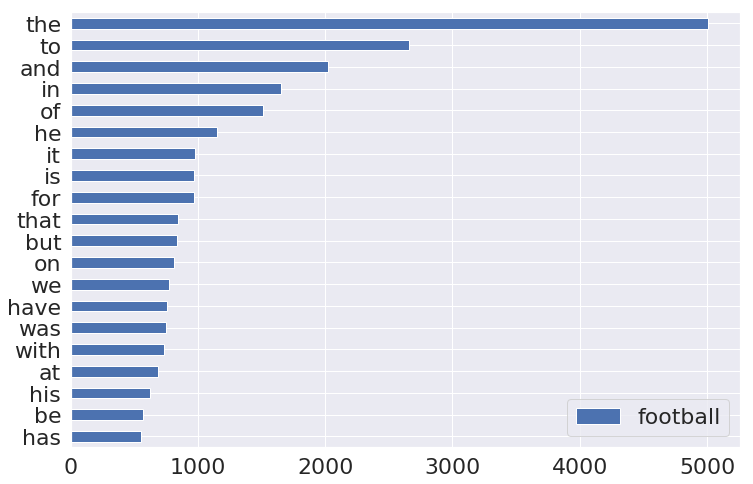

Top words for category : rugby


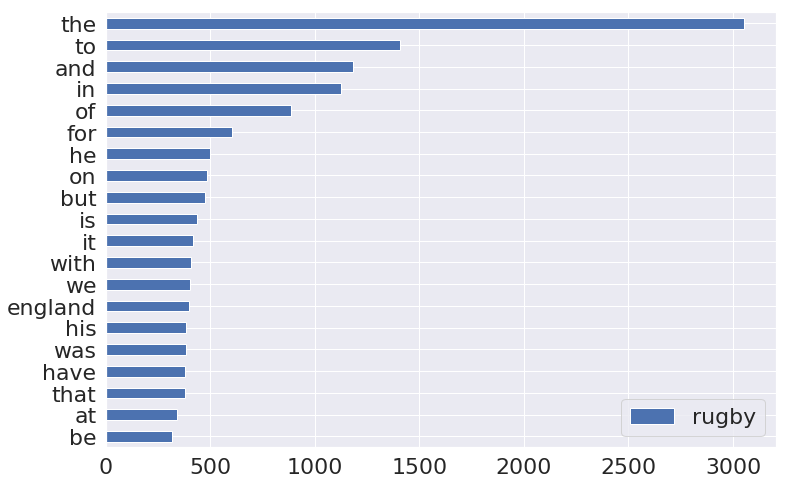

Top words for category : tennis


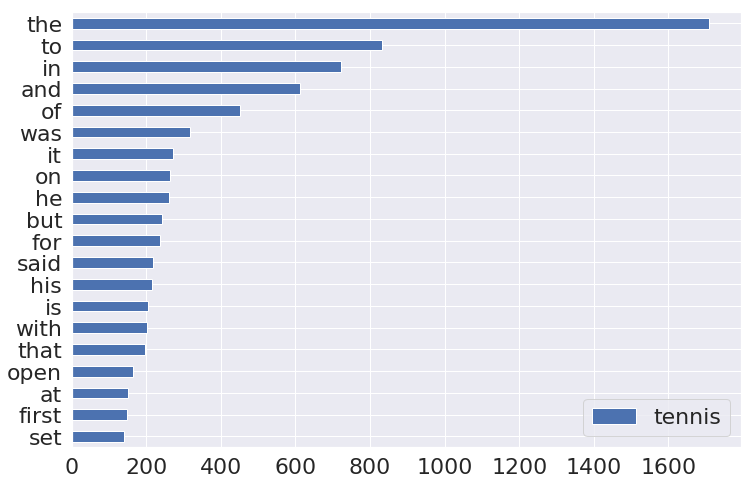

In [4]:
# Explore top owrds by class

top_nw = 20 
data_ds = pd.Series(documents.data)
target_ds = pd.Series(documents.target)
top_words = pd.DataFrame(None, columns = cat_names, index = range(top_nw))


for i, c in enumerate(cat_names):
    all_txt = data_ds[target_ds==i]
    test_vectorizer = CountVectorizer()
    all_txt_vect = test_vectorizer.fit_transform(all_txt)

    word_frecs = all_txt_vect.sum(axis = 0)
    print('Top words for category :', c)
    f, ax = plt.subplots(figsize = (12,8))
    pd.DataFrame(word_frecs,  columns = test_vectorizer.get_feature_names(), index = [c]).T.sort_values(
                  by =[c], ascending = False).head(top_nw).plot(kind = 'barh', ax = ax)
    
    plt.gca().invert_yaxis()
    plt.show()

### Base Model

In [5]:
# Set base model classifying to bigger category, i.e. classif all to tags median
y_pred_median = np.ones(shape = (y_valid.shape)) * category_proportions.values.argmax()
y_valid
performance_metric_name = 'F1'
score_avg = 'macro'

base_model_f1= metrics.f1_score(y_pred_median, y_valid, average=score_avg)
print("Base model classifying all to the median.  %s '%s' Score: %.2f %%"% (performance_metric_name
                                                                , score_avg, base_model_f1*100))

Base model classifying all to the median.  F1 'macro' Score: 9.67 %


Our base model, which classifies all instances with the target median gives us a F1 with a weighting 'macro' strategy to give a bigger penalization when instances from small proportion classes are badly classified. If the models that will be consturcted, do not outperform this result, we would have to go back and rethink our approach to the problem.

## Work Flow

We have already loaded and separated the available data into training and test sets and established our base model. To train and compare multiple models we will perform the next steps using pipe lines. This will allow to apply sequential transformations and evaluations using k folds cross validation. The full Work flow its details are shown below. 

In [6]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "images/workFlowc.png")

### Text Preprocessing and Vectorization

You can see that the first part of the pipe line executes the preprocessing of each document's text. This step is necessary to filter words that would not be useful reducing, like that, the dimentionallity of the data sets. 

All text preprocess will be done by a function which  includes following tasks:  
__lower case tranformation__ : Use only low case characters.
__remove numbers__: Use only alpha numeric characters
__remove special characters__ : To remove punctuation and other special characters.
__remove stop words__ : Remove stop words such as  and, for, etc.
__word stemming__ : To use the stem of each word instead of the word itself. For example use histori instead of hystory, historian, etc.

All these steps are placed on a function that executes them to the passed string.

The result in the first 220 characters of the first document 

In [7]:
#  Custom functions  for text preprocessing in to a custom CountVectorizer
english_stemmer = nltk.stem.SnowballStemmer('english')
def text_preprocess(txt, lower_case = True, remove_numbers = True, remove_special_chars=True
                       , remove_stop_words = True, stem=True, keep_words_over_nchars = 3 ):
    txt = (txt.lower() if lower_case else txt)
    txt = (re.sub(r'\d+', '', txt) if remove_numbers else txt)
    nchar = str(keep_words_over_nchars)
    txt = (re.sub(r'[^\w{'+nchar+',}\s]','', txt) if remove_special_chars else txt)
    txt = (' '.join([i for i in txt.split() if not i in stopwords.words('english')]
                    if remove_stop_words else txt))
    txt = (' '.join([english_stemmer.stem(w) for w in txt.split()] if stem else txt))
    return txt

#Make a test small text using the first document
first_doct_txt = documents.data[0][0:220]
print(first_doct_txt)
text_preprocess(first_doct_txt) #Test text-preprocess fn


England victory tainted by history

As England attempt to secure a series victory in South Africa, they will do so at the venue for a previous match which became the stuff of Test cricket folklore.

South Africa's meetin


'england victori taint histori england attempt secur seri victori south africa, venu previous match becam stuff test cricket folklor south africa meetin'

### Text vectorization

Top words for category : athletics


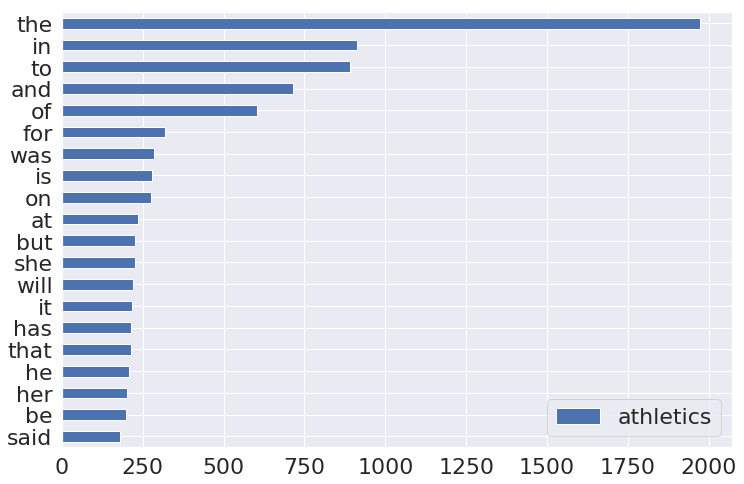

Top words for category : cricket


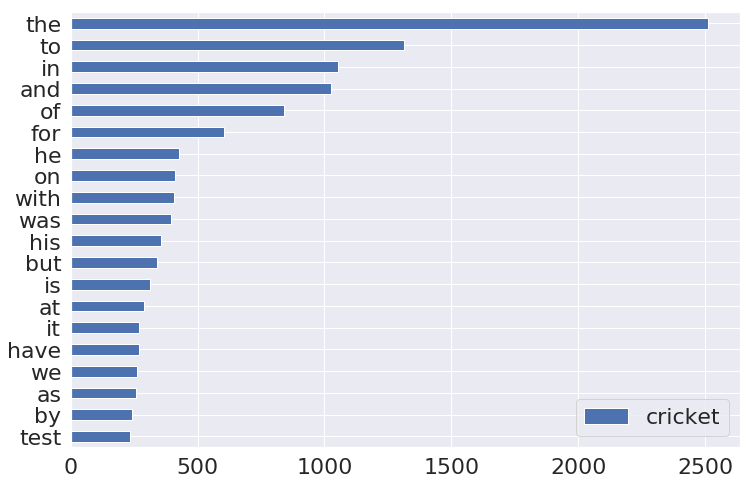

Top words for category : football


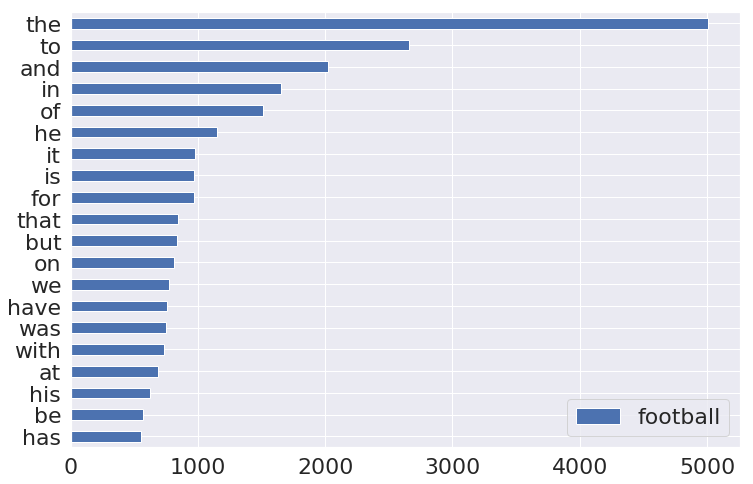

Top words for category : rugby


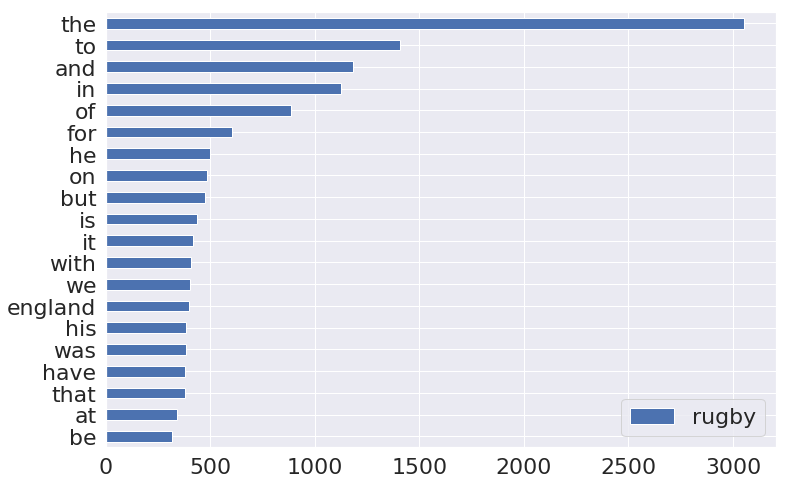

Top words for category : tennis


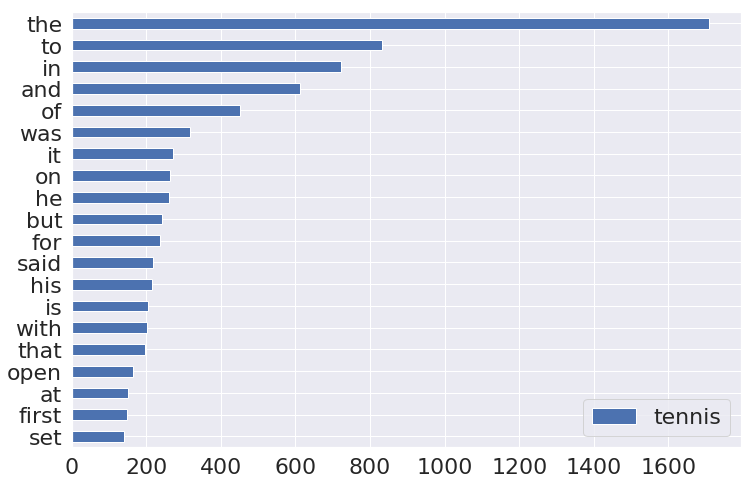

In [8]:
# Explore top owrds by class

top_nw = 20 
data_ds = pd.Series(documents.data)
target_ds = pd.Series(documents.target)
top_words = pd.DataFrame(None, columns = cat_names, index = range(top_nw))


for i, c in enumerate(cat_names):
    all_txt = data_ds[target_ds==i]
    test_vectorizer = CountVectorizer()
    all_txt_vect = test_vectorizer.fit_transform(all_txt)

    word_frecs = all_txt_vect.sum(axis = 0)
    print('Top words for category :', c)
    f, ax = plt.subplots(figsize = (12,8))
    pd.DataFrame(word_frecs,  columns = test_vectorizer.get_feature_names(), index = [c]).T.sort_values(
                  by =[c], ascending = False).head(top_nw).plot(kind = 'barh', ax = ax)
    
    plt.gca().invert_yaxis()
    plt.show()

After filtering and stemming the document's text it needs to be transformed in to a numeric matrix to be fed to any classification model.  We can use a CountVectorizer object from sci-kit learn to do this transformation. However, in order to carry out all the sequence of steps defined in the text pre-processing function, it will be necessary to make an ad-hoc vectorizer. Our vectorizer will return the count of the lower case non filtered stemmed words as we can see below with the the same sub string of the first document. We can see how, with text data, the features are the words contained in the documents. 

In [9]:
class CustomPreprocCountVectorizer(CountVectorizer):
    """Class to extend CountVectorizer with text pre processing stemming"""
    def build_analyzer(self):
        analyzer = super(CustomPreprocCountVectorizer, self).build_analyzer()
        return lambda doc: ([text_preprocess(w) for w in analyzer(doc)])


In [10]:
# Test our custom vectorizer with our small first document sub text
test_text = [text_preprocess(documents.data[0][0:220])] #Test text-preprocess fn
test_vectorizer = CustomPreprocCountVectorizer()
text_text_vect = test_vectorizer.fit_transform(test_text)
pd.DataFrame(text_text_vect.todense(), columns =  test_vectorizer.get_feature_names())


,africa,attempt,becam,cricket,england,folklor,histori,match,meetin,previous,secur,seri,south,stuff,taint,test,venu,victori
0,2,1,1,1,2,1,1,1,1,1,1,1,2,1,1,1,1,2


After performing word processing, we repeat now the exploration of the most frequent words for each category.. It's now evident that the terms seem to be much more relevant.

Top words for category : athletics


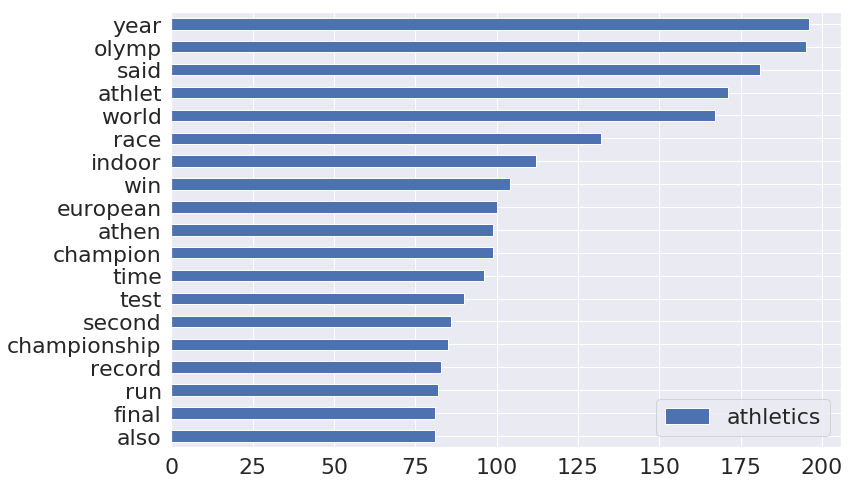

Top words for category : cricket


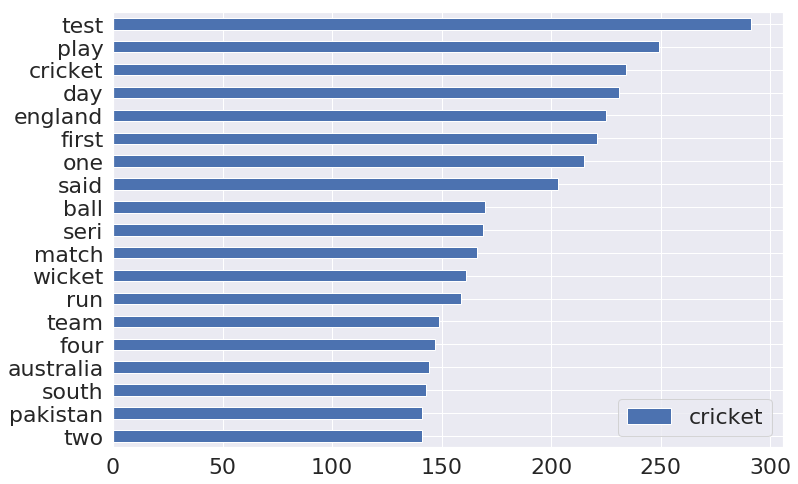

Top words for category : football


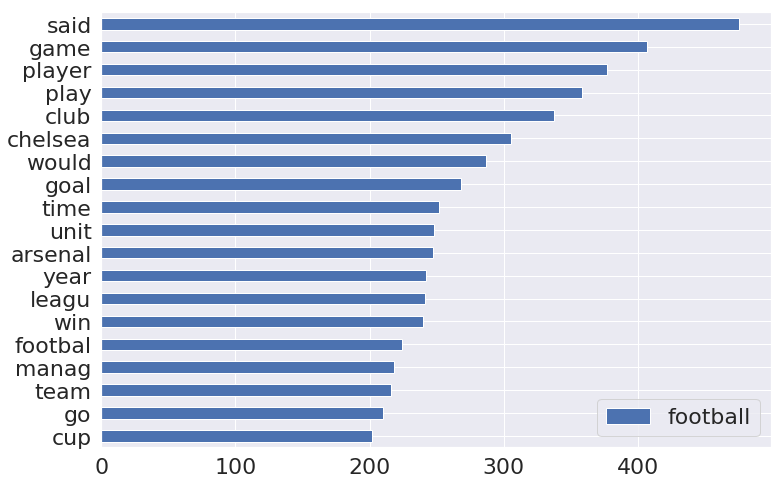

Top words for category : rugby


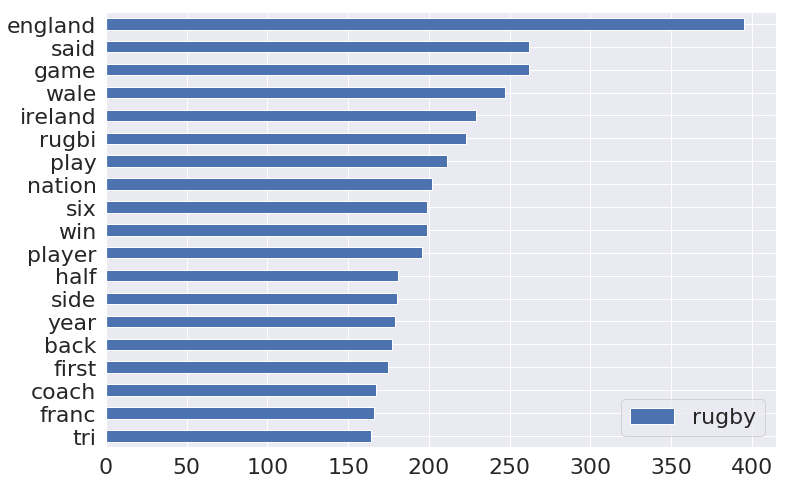

Top words for category : tennis


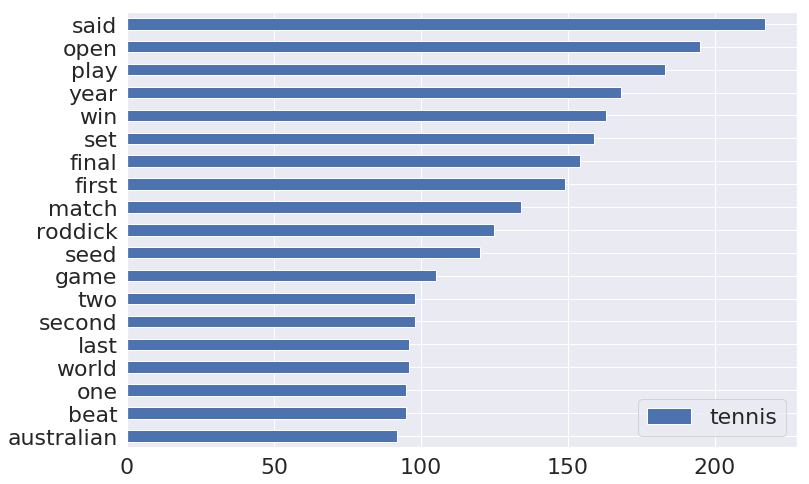

In [11]:
# Explore top owrds by class

top_nw = 20 
data_ds = pd.Series(documents.data)
target_ds = pd.Series(documents.target)
top_words = pd.DataFrame(None, columns = cat_names, index = range(top_nw))


for i, c in enumerate(cat_names):
    all_txt = data_ds[target_ds==i]
    test_vectorizer = CustomPreprocCountVectorizer()
    all_txt_vect = test_vectorizer.fit_transform(all_txt)

    word_frecs = all_txt_vect.sum(axis = 0)
    print('Top words for category :', c)
    f, ax = plt.subplots(figsize = (12,8))
    pd.DataFrame(word_frecs,  columns = test_vectorizer.get_feature_names(), index = [c]).T.sort_values(
                  by =[c], ascending = False).head(top_nw).drop('').plot(kind = 'barh', ax = ax)
    
    plt.gca().invert_yaxis()
    plt.show()


#### Feature Engineering and Feature Selection
The next step in the first pipe line is to transform the characteristics. We will perform the following tasks:

__Transformation TFIDF__: To increase the weight of terms that have a high frequency especially in one of the categories and reduce that of those with high frequency uniformly in all categories.

__Dimensionality reduction__:Using the truncated singular value decomposition (SVD) which can be applied to the sparse matrix returned by the TFIDF transformation.
Feature Scaling: Using MaxAbsScaler() which will bring all values within -1 and 1.

__Feature Selection__: Using a model based selection given by a Lasso Logistic Regression. 

All these options will affect the performance of our final model so different values of them will be tested on the pipe line using cross validation. Finally, giving that the nature of all these steps are computationally costly, the result it will be saved to disk, to be loaded to perform the next pipe line step where all model parameters will be tested.

### Model Selection
The last step of the pipe line is to test few models using different parameters. This is done on a loop testing every model  calling the persisted feature engineering pipe line together with the model's parameter options to perform a grid search on all possible combinations. 

In [12]:
# Custom function to allow the SVD transformation to be skipped under a pipe line
class SkippableTruncatedSVD(decomposition.TruncatedSVD):
    #Source http://queirozf.com/entries/scikit-learn-pipeline-examples#skip-or-disable-a-step-in-pipeline
    # add the "skip" argument and keep the others as in the superclass
    def __init__(self, skip=False,n_components=2, algorithm="randomized", n_iter=5,
                 random_state=None, tol=0.):
        self.skip = skip
        super().__init__(n_components, algorithm, n_iter, random_state, tol)

    # execute if not being skipped
    def fit(self, X, y=None):
        if self.skip:
            return self
        else:
            return super().fit(X,y)

    # execute if not being skipped
    def fit_transform(self, X, y=None):
        if self.skip:
            return X
        else:
            return super().fit_transform(X,y) 

    # execute if not being skipped
    def transform(self, X):
        if self.skip:
            return X
        else:
            return super().transform(X) 

In [13]:
# =======================Training Pipeline=================================
from sklearn import pipeline
#from sklearn.linear_model import LogisticRegressionCV
from sklearn import model_selection
from tempfile import mkdtemp
from joblib import Memory
from sklearn.feature_selection import chi2, SelectPercentile #SelectFromModel
from aux_functions_mod import (SkippableTruncatedSVD, CustomPreprocCountVectorizer
                               ) #, DenseTransformer

# Set temp storage to cache first pipe transformations
#cachedir = mkdtemp()
#memory = Memory(location=cachedir, verbose=0)


# Set model for feature selection using SelectFromModel
#feature_selector_model  = LogisticRegressionCV(Cs=10, n_jobs=1, penalty='l2')

cached_pipe = pipeline.Pipeline([
          ('vectorizer', CustomPreprocCountVectorizer())
         ,('tfidf', TfidfTransformer())
         ,('reduce_dim', SkippableTruncatedSVD(random_state=FIX_RAND_STATE)) #decomposition.TruncatedSVD()
         #, ('sparse2dense', DenseTransformer())
         ,('scaler', preprocessing.MinMaxScaler())
         ,('ftr_select_percent',  SelectPercentile(score_func= chi2)) #SelectFromModel(feature_selector_model))
         ] #, ('top_ftrs', top_ftr_selector)
         #, memory=memory #To persist in memory if too big to store in memory
         )


## Delete the temporary cache
#before exiting
#from shutil import rmtree
#rmtree(cachedir)


params_grid = {
                'tfidf__use_idf': [True]#, False
               , 'vectorizer__max_df': [0.7] #, 0.8, 0.9 .7 to detect and filter stop words 
               , 'vectorizer__ngram_range': [(1,1)]  #, (1, 2) unigrams or bigrams
               , 'reduce_dim__n_components': [100] #, 300  
               , 'reduce_dim__skip': [False] #, True
               , 'ftr_select_percent__percentile': [5] #, 10, 20, 40Retain nth perc
               #, 'feature_select__threshold': [.05, .1] # Drops features with weights under threshold
             }


# Set models and hyperparameters
models = [
          #  ('nb', naive_bayes.MultinomialNB())
          # ('lasso', linear_model.LogisticRegression( random_state=FIX_RAND_STATE
          #                                            , multi_class ='ovr'
          #                                            , solver = 'liblinear'
          #                                            ))
          #, ('svm', svm.SVC(probability=True, random_state=FIX_RAND_STATE))
           ('rf', ensemble.RandomForestClassifier( random_state=FIX_RAND_STATE )) #random_state=FIX_RAND_STATE
          #, ('sk_xgb', ensemble.GradientBoostingClassifier(random_state=FIX_RAND_STATE))
          , ('xgb', xgboost.XGBClassifier(random_state=FIX_RAND_STATE))
          ]

modelsDic = dict(models)


model_params = {
              #   'nb__alpha': [1.0]
              # 'lasso__C': [1] #.001,.01, .1, 1, 10, 100, 1000, 10000, 100000
              #,  'lasso__penalty':['l2'] #'l1',
              #, 'svm__C': [1] #.001,.01, .1, 1, 10, 100, 1000, 10000, 100000
              #, 'svm__kernel':  ['linear', 'rbf']
               'rf__max_features':['sqrt'] #, 'log2', 'auto'
              , 'rf__n_estimators': [1000]
              #, 'sk_xgb__max_depth':[2,3]
              #, 'sk_xgb__subsample': [1.0]
              #, 'sk_xgb__max_features':['auto', 'sqrt', 'log2']
              #, 'sk_xgb__n_estimators':[500]
              , 'xgb__learning_rate':[0.01]
              , 'xgb__max_depth':[3] #2,3,4
              , 'xgb__colsample_bytree':[.7] #
              , 'xgb__subsample': [.8]
              , 'xgb__objective': ['binary:logistic']
              , 'xgb__gamma':[1]
              , 'xgb__n_estimators': [1000]
        }


preproc_hparams_count = np.prod([len(params_grid[k]) for k in params_grid.keys()])
model_params_count = np.prod([len(model_params[k]) for k in model_params.keys()])
combinations = preproc_hparams_count * model_params_count
print('Total grid search space size: %.d combinations to test'% ( combinations) )

scores = {}
ftr_compress = False
folds = 10
 
import time #Measure gridSearchCV execution time
start = time.time()

for model_name in list(modelsDic.keys()):
    print('Training model %s ...' % model_name)
    pipe = cached_pipe
    pipe.steps.append((model_name, modelsDic[model_name]))
    
    #Add only model_name parameters to the grid dict
    filtered_params = params_grid.copy() #Initialize with preprocess variations to test
    for key in model_params.keys():
        if model_name in key:
            filtered_params[key]=model_params[key]
    cv_splitter = model_selection.StratifiedKFold(n_splits=folds
                                  , random_state=FIX_RAND_STATE)
    accuracy_metric = metrics.make_scorer(metrics.accuracy_score)#, average = score_avg
    gs = model_selection.GridSearchCV(estimator=pipe, param_grid = filtered_params
                                  , cv = cv_splitter, n_jobs=-1,  scoring = accuracy_metric)
    print(filtered_params)
    
    gs.fit(X_train, y_train)
    scores[model_name] = None
    scores[model_name]={'best_score':  gs.best_score_}
    print("Best {}: {:.4f} with params: {}: ".format( performance_metric_name
                                          , gs.best_score_, gs.best_params_))
    pipe.steps.pop()   #Pop model in turn from pipe

    # Store best model results to plot i.e  those corresponding to best model params
    cv_results_df = pd.DataFrame(gs.cv_results_)
    # Get the best candidate parameter setting.
    scores[model_name]['cv_optim_result'] = cv_results_df.loc[gs.best_index_,:]
    scores[model_name]['best_estimator'] = gs.best_estimator_
        
end = time.time()
total_elapsed_seconds = end - start
print('Grid search elapsed time: %.2f minutes'% (total_elapsed_seconds/60))


Total grid search space size: 1 combinations to test
Training model rf ...
{'rf__n_estimators': [1000], 'ftr_select_percent__percentile': [5], 'reduce_dim__n_components': [100], 'vectorizer__max_df': [0.7], 'tfidf__use_idf': [True], 'rf__max_features': ['sqrt'], 'reduce_dim__skip': [False], 'vectorizer__ngram_range': [(1, 1)]}
Best F1: 0.9620 with params: {'rf__n_estimators': 1000, 'ftr_select_percent__percentile': 5, 'reduce_dim__n_components': 100, 'vectorizer__max_df': 0.7, 'tfidf__use_idf': True, 'vectorizer__ngram_range': (1, 1), 'reduce_dim__skip': False, 'rf__max_features': 'sqrt'}: 
Training model xgb ...
{'reduce_dim__n_components': [100], 'vectorizer__max_df': [0.7], 'tfidf__use_idf': [True], 'vectorizer__ngram_range': [(1, 1)], 'xgb__objective': ['binary:logistic'], 'xgb__max_depth': [3], 'ftr_select_percent__percentile': [5], 'xgb__learning_rate': [0.01], 'xgb__colsample_bytree': [0.7], 'reduce_dim__skip': [False], 'xgb__subsample': [0.8], 'xgb__gamma': [1], 'xgb__n_estimat

In [14]:
### Save scores object on disk
#import pickle 

#scores_pickle = open('data/scores.pkl', 'wb') if os.path.exists('data/scores.pkl') else None 
#cv_results_df_pickle = open('data/cv_results_df.pkl', 'wb') if (
#                                         os.path.exists('data/cv_results_df.pkl')) else None
#pickle.dump(scores, scores_pickle)

## Read back
#filehandler = open('data/scores.pkl', 'rb') 
#scores = pickle.load(filehandler)



In [15]:
# Build Optimal results DF to plot
optim_results_df = pd.DataFrame(None
                        , columns = [c for c in scores[list(scores.keys())[0]]['cv_optim_result'].index
                                                       if 'param' not in c]
                        , index = list(scores.keys()))
for m in optim_results_df.index:
    no_parameter_cols = [c for c in scores[m]['cv_optim_result'].index if 'param' not in c]
    optim_results_df.loc[m,:] = scores[m]['cv_optim_result'].loc[no_parameter_cols].values



# Plot
def plot_cv_intervals(df, mean_col, std_col, ylabel = "", figsize = (6,4)):
    f, ax= plt.subplots(figsize = figsize)
    x,y,e = (list(df.index), df[mean_col]
             , df[std_col])
    plt.errorbar(x, y, e, linestyle='None', marker='^')
    plt.title('Models %d folds CV performance' % folds)
    plt.ylabel('%s' % ylabel)
    
    plt.show()


The result shows how the ML models outperform our base model. We can also inspect the execution time for all classifiers optimal estimators. Ensemble methods take more time to be trained but they also give better performance.

In [16]:
import  sklearn.metrics
max_overall_performance = optim_results_df.loc[:,'mean_test_score'].agg(np.max) 

best_model_name = list(optim_results_df.loc[optim_results_df['mean_test_score']
                                ==max_overall_performance,:].index)[0]
best_model = scores[best_model_name]['best_estimator']
y_valid_preds = best_model.predict(X_valid)

In [17]:
print('Best estimators summaries by classifier')
optim_results_df

Best estimators summaries by classifier


,mean_fit_time,mean_score_time,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,std_fit_time,std_score_time,std_test_score
rf,61.8905,6.84808,0.961957,1,1,0.928571,0.910714,0.964286,0.946429,1,0.963636,0.962963,0.981132,0.962264,11.1433,1.35451,0.0271374
xgb,61.3362,6.04228,0.960145,1,1,0.928571,0.910714,0.964286,0.910714,1,0.963636,0.944444,0.981132,1,13.4257,1.5184,0.0338221


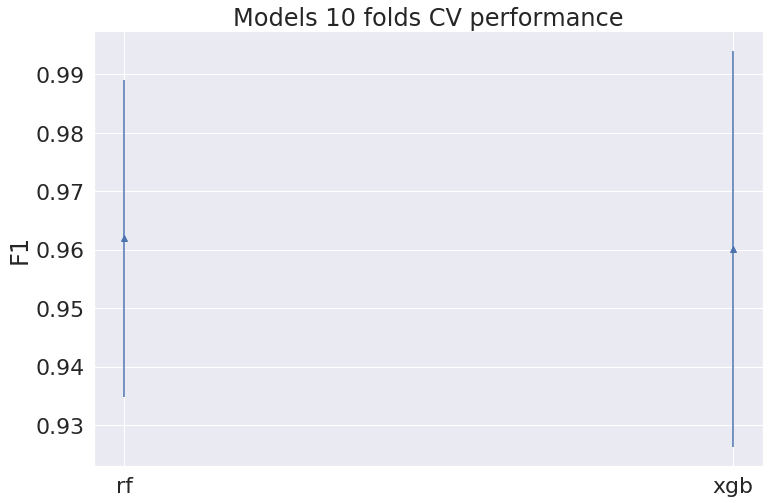

In [18]:
# Compare scores
plot_cv_intervals(optim_results_df, 'mean_test_score'
                  , 'std_test_score', performance_metric_name, figsize = (12,8))

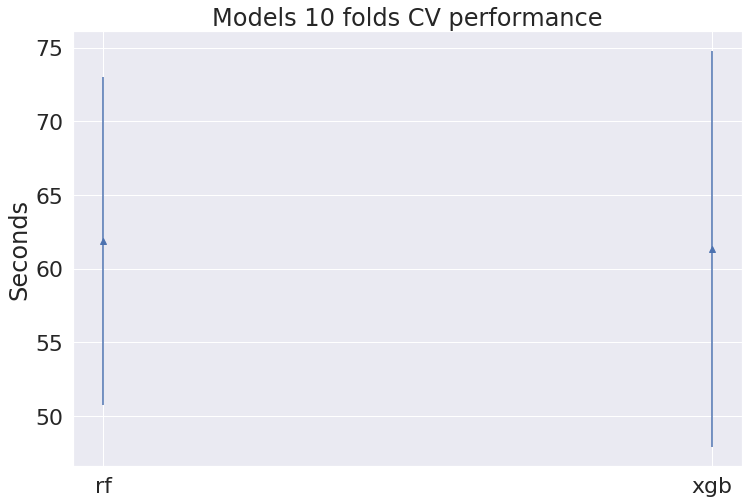

In [19]:

# Compare fit times of optimal models
plot_cv_intervals(optim_results_df, 'mean_fit_time'
                  , 'std_fit_time', 'Seconds', figsize = (12,8))

Let's check the best estimator parameter and hyperparameters and it's performance on the reserved unseen samples.

In [20]:

# Calculate score on eval set
eval_set_f1 = metrics.f1_score(y_valid, y_valid_preds, average = score_avg)  
print('F1 score on unseen examples: %.2f' % eval_set_f1 )

y_valid_pred_proba = pd.DataFrame(best_model.predict_proba(X_valid), columns = cat_names)
y_valid_pred = pd.DataFrame(best_model.predict(X_valid), columns = ['predicted_value'])



F1 score on unseen examples: 0.95


In [21]:
#print('Best %s %s parameters:' % (best_model_name, scores[best_model_name]['best_estimator']))
scores[best_model_name]['best_estimator'].named_steps[best_model_name]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=421,
                       verbose=0, warm_start=False)

Although the optimal estimator is much better than the base estimator, there is a proportion of misclassified instances as can be seen in the confusion matrix below.

In [22]:
# Confussion matrix
conf_matrix = metrics.confusion_matrix(y_valid, y_valid_preds)
pd.DataFrame(conf_matrix, columns = cat_names, index = cat_names)


,athletics,cricket,football,rugby,tennis
athletics,28,0,3,0,0
cricket,0,33,0,0,0
football,0,0,56,3,0
rugby,0,0,3,37,0
tennis,0,0,1,0,21


It seems that the classifier has more difficulty descerning between football and rugby, as well as between rugby and cricket. Let's explore the detail of the probabilities assigned to the some unseen instances.

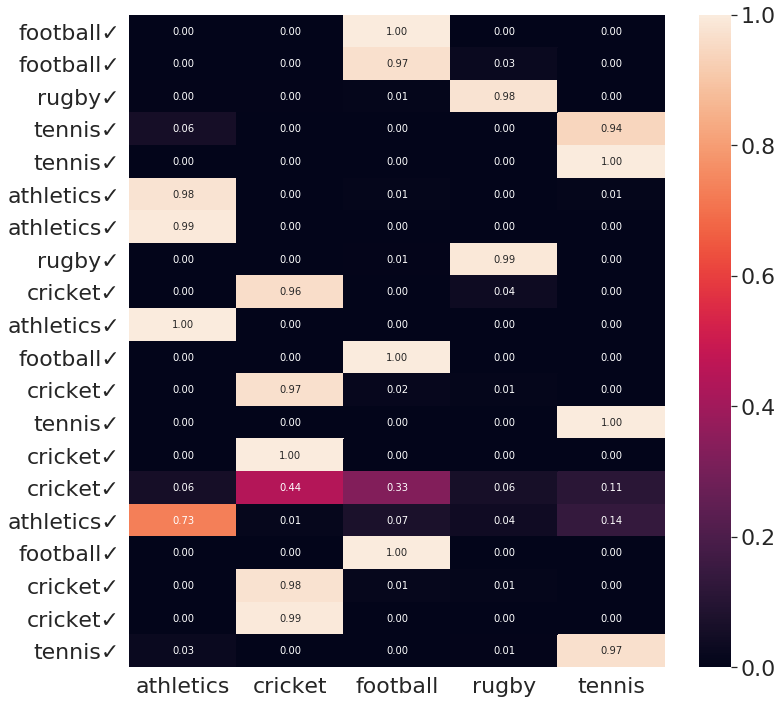

In [23]:
# Plot eval set first examples probabilities
f, ax = plt.subplots(figsize = (12,12))
explore_n = len(y_valid_pred_proba)
pred_checkmark = ['✓' if (t[0]==t[1]) else 'x' for t in  zip(y_valid_pred.values.ravel(), y_valid)]

val_data_explore = pd.DataFrame(y_valid_pred_proba[0:explore_n].values
                                , index = [cat_names[i] for i in y_valid[0:explore_n]]
                                , columns = cat_names)
val_data_explore.index = val_data_explore.index + pred_checkmark

bad_predicts_mask = (np.array([s[-1] for s in val_data_explore.index]) == 'x')

sns.heatmap(val_data_explore.head(20), annot=True, fmt=".2f", ax = ax)

#for c in ['athleticsx', 'cricketx', 'footballx', 'rugbyx', 'tennisx'][3:4]:
#    #f, ax = plt.subplots(figsize = (10,10))
#    sns.heatmap(val_data_explore[bad_predicts_mask].loc[c,:]
#                , annot=True, fmt=".2f", ax = ax)
#    plt.show()

### Classifier logic

We can instpect forward to try to find out the way the models logic classifying particular predictions. First let explore a right classified one.

In [24]:
# Load and charge Best Model
# Save best model
from joblib import dump, load
#best_estimator = best_model
#dump(best_estimator, 'data/best_estimator.joblib') 

best_estimator = load('data/best_estimator.joblib')
#best_estimator.predict(X_valid[0:4]) #ray([3, 1, 2, 3])

Fist, let's explore a correctly predicted  football instance.

In [25]:
# Inspect badly classified instances
eval_preds = pd.DataFrame({  'txt':X_valid
                              , 'y_valid':y_valid
                              , 'y_valid_pred': y_valid_pred.values.ravel()
                             })
correct_preds_mask = eval_preds.y_valid == eval_preds.y_valid_pred
correct_preds = eval_preds.loc[correct_preds_mask,:]
print(cat_names)
correct_preds.head(10)

['athletics', 'cricket', 'football', 'rugby', 'tennis']


,txt,y_valid,y_valid_pred
0,Thompson says Gerrard should stay\n\nLiverpool...,2,2
1,Blatter suggests offside change\n\nFifa presid...,2,2
2,Dawson set for new Wasps contract\n\nEuropean ...,3,3
3,Federer joins all-time greats\n\nThe last year...,4,4
4,Edgy Agassi struggles past Dent\n\nAndre Agass...,4,4
5,Disappointed Scott in solid start\n\nAllan Sco...,0,0
6,Greek duo cleared in doping case\n\nSprinters ...,0,0
7,Murray returns to Scotland fold\n\nEuan Murray...,3,3
8,Sri Lanka decide to continue tour\n\nSri Lanka...,1,1
9,Isinbayeva claims new world best\n\nPole vault...,0,0


In [26]:
from lime.lime_text import LimeTextExplainer
top_n_ftrs = 10
explainer = LimeTextExplainer(class_names=cat_names)

nth = correct_preds.index[4]
print('Explored case index: %d'% nth)
exp = explainer.explain_instance(correct_preds.loc[nth, 'txt']
                            , scores[best_model_name]['best_estimator'].predict_proba
                            , num_features=top_n_ftrs
                            , top_labels=2)


exp.show_in_notebook(text=False)

Explored case index: 4


We can se that the classifier's logic like the words Agassi, Austalian Open and seed help to identify the instance as belonging to the tennis class. Those words are also on the top words related with that category 

Finally, lest explore a badly predicted instance.

In [27]:
incorrect_preds = eval_preds.loc[np.invert(correct_preds_mask),:]
print(cat_names)
incorrect_preds.head(12)

['athletics', 'cricket', 'football', 'rugby', 'tennis']


,txt,y_valid,y_valid_pred
44,Costin aims for comeback in 2006\n\nJamie Cost...,0,2
68,Freeman considers return to track\n\nFormer Ol...,0,2
98,Hereford 1-1 Doncaster\n\nHereford win 3-1 on ...,2,3
113,Kafer quits Saracens\n\nSaracens head coach Ro...,3,2
117,Hansen 'delays return until 2006'\n\nBritish t...,0,2
124,Irish finish with home game\n\nRepublic of Ire...,2,3
131,Australia miss Molik for Fed Cup\n\nAustralia ...,4,2
134,Farrell saga to drag on - Lindsay\n\nWigan cha...,3,2
157,Hearts of Oak 3-2 Cotonsport\n\nHearts of Oak ...,2,3
178,Munster Cup tie switched to Spain\n\nMunster's...,3,2


In [28]:
from lime.lime_text import LimeTextExplainer
top_n_ftrs = 12
explainer = LimeTextExplainer(class_names=cat_names)
nth = incorrect_preds.index[2]
print('Explored case index: %d'% nth)
exp = explainer.explain_instance(incorrect_preds.loc[nth, 'txt']
                            , scores[best_model_name]['best_estimator'].predict_proba
                            , num_features=top_n_ftrs
                            , top_labels=2)


exp.show_in_notebook(text=False)
.

Explored case index: 98


This case was misclassified as being from the rugby class when it is from the football one. The principal words influencing the classification are the words penalty and Robinson which, in fact, could be very likely be used in any of the two kind of categories. On the other hand, words influencing towards de football classification could also belong to any of the two categories. So it seems that this kind of misclassifications should be difficult even for a human reader.

## Discussion and next steps

The work presented in this notepad has allowed us to build an automatic text classifier with a classification capacity far superior to the base classifier built using the mean of the target feature. 

The classifier can get a very high accuracy using the F1 metric and seems to identify pretty well most of the instances. It allows also to identify relevant features for classification on particular instances. 

Finally, a dashboard showing examples and predictions can be found [here]( https://txt-classifier.herokuapp.com/). It allows to easily explore  each example predicted probabilities to becom to each category as well as the text contained in the document.  
